# Feature Engineering

---

*Features*

- 7 new featurs are created:
    * document length, raw
    * document length, clean
    * token, number of
    * token length, max
    * token length, mean
    * token length, std
    * right-side ratio (rsr)
        - see details about this curious metric in [this notebook](./Extra_The_QWERTY_Effect.ipynb)
    
*Results*

- After some visualizations, the first feature (raw document length) appears to be the most useful in separating the target
- The last feature (rsr) appears to be the least useful
- These features will be evaluated in combination with Bag-of-Bigrams and SVD representations in the next notebook
 

### Setup

In [1]:
import os
import time

import numpy as np
import pandas as pd

from datetime import datetime

start_time = time.time()
dt_object = datetime.fromtimestamp(time.time())
day, T = str(dt_object).split('.')[0].split(' ')
print('Revised on: ' + day)

Revised on: 2020-12-07


### Load Data

In [2]:
import json
import urlextract
from nltk.stem import WordNetLemmatizer

def load_data(data):
    raw_path = os.path.join("..","data","1_raw")
    filename = ''.join([data, ".csv"])
    out_dfm = pd.read_csv(os.path.join(raw_path, filename))
    out_arr = np.array(out_dfm.iloc[:,0].ravel())
    return out_arr

X_train = load_data("X_train")
y_train = load_data("y_train")

# load contractions map for custom cleanup
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

### New Features

In [3]:
%%capture output

# custom feature engineering module
import feature_engineering as Fe

try:
    clean_train_docs, X_train_feat = Fe.DocumentToFeaturesCounterTransformer().fit_transform(X_train)
except Warning as e:
    pass # avoids RuntimeErrors because of divisions by zero in calculating means/stds

### Impute `nan` with $0$

In [4]:
[(ix, val) for ix, val in enumerate(X_train[12:15])]

[(0, "K come to nordstrom when you're done"),
 (1, ':-) :-)'),
 (2, 'Okay... I booked all already... Including the one at bugis.')]

In [5]:
[(ix, val) for ix, val in enumerate(clean_train_docs[12:15])]

[(0, 'k come to nordstrom when you are done'),
 (1, ''),
 (2, 'okay i booked all already including the one at bugis')]

In the new feature space - columns:
1. Document length, raw
2. Document length, clean
3. Number of tokens
4. Token length, max
5. Token length, mean
6. Token length, std
7. Right-side ratio

In [6]:
print(X_train_feat[12:15])

[[36.     37.      8.      9.      3.75    2.222   0.5   ]
 [ 7.      0.      0.      0.         nan     nan  0.    ]
 [59.     52.     10.      9.      4.3     2.3259  0.5116]]


In [7]:
# impute with zeros
X_train_feat[np.isnan(X_train_feat)] = 0
print(X_train_feat[12:15])

[[36.     37.      8.      9.      3.75    2.222   0.5   ]
 [ 7.      0.      0.      0.      0.      0.      0.    ]
 [59.     52.     10.      9.      4.3     2.3259  0.5116]]


### Visualising new features

In [8]:
viz = pd.DataFrame(X_train_feat,
                   columns=["doclen_raw","doclen_cln",
                             "n_tokens","token_maxlen",
                             "token_meanlen","token_stdlen","rsr"])
# reload labels
y_train_str = load_data("y_train")
viz["target"] = y_train_str

In [9]:
viz.head()

,doclen_raw,doclen_cln,n_tokens,token_maxlen,token_meanlen,token_stdlen,rsr,target
0,53.0,50.0,9.0,9.0,4.6667,2.2111,0.4524,ham
1,160.0,155.0,33.0,7.0,3.7273,1.3545,0.4309,spam
2,75.0,69.0,14.0,7.0,4.0000,1.7321,0.5000,ham
3,37.0,37.0,8.0,8.0,3.7500,2.4367,0.4333,ham
4,73.0,65.0,13.0,8.0,4.0769,1.8589,0.4906,ham


In [10]:
viz.describe()

,doclen_raw,doclen_cln,n_tokens,token_maxlen,token_meanlen,token_stdlen,rsr
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,79.714359,75.913333,15.860000,7.736667,3.834410,1.791610,0.475802
std,58.108675,55.704255,11.300593,2.620698,0.690138,0.616968,0.087486
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.000000,33.750000,7.000000,6.000000,3.400000,1.414200,0.424575
50%,61.000000,57.000000,12.000000,7.000000,3.777800,1.758200,0.471400
75%,121.000000,114.000000,23.000000,9.000000,4.200000,2.103400,0.520100
max,790.000000,781.000000,172.000000,37.000000,10.500000,6.676200,1.000000


In [11]:
# separate out positives and negatives for plotting
X_pos = viz[viz.target == "spam"]
X_neg = viz[viz.target == "ham"]

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_target_hist(X_pos, X_neg, feat_name, bins=100, log_=False):
    
    if log_:
        pos_ = np.log(X_pos[feat_name])
        neg_ = np.log(X_neg[feat_name])
        xlab = ' '.join(["Log", feat_name])
    else:
        pos_ = X_pos[feat_name]
        neg_ = X_neg[feat_name]
        xlab = feat_name
        
    plt.figure(figsize=(12, 6))    
    plt.hist(pos_, bins=bins, alpha=0.5, label="spam")
    plt.hist(neg_, bins=bins, alpha=0.5, label="ham")
    plt.xlabel(xlab, size=14)
    plt.ylabel("Count", size=14)
    plt.legend(loc='upper right')
    plt.show()

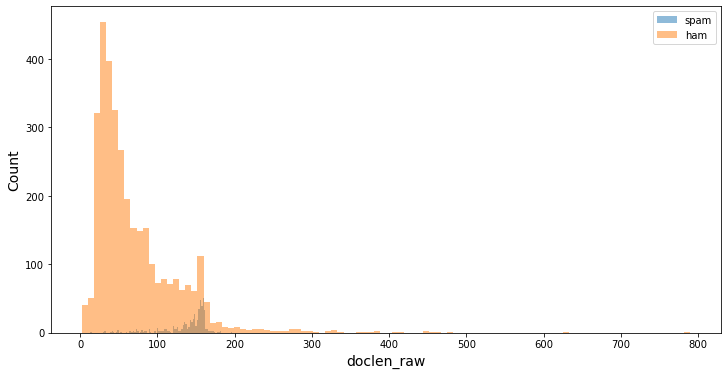

In [13]:
plot_target_hist(X_pos, X_neg, "doclen_raw")

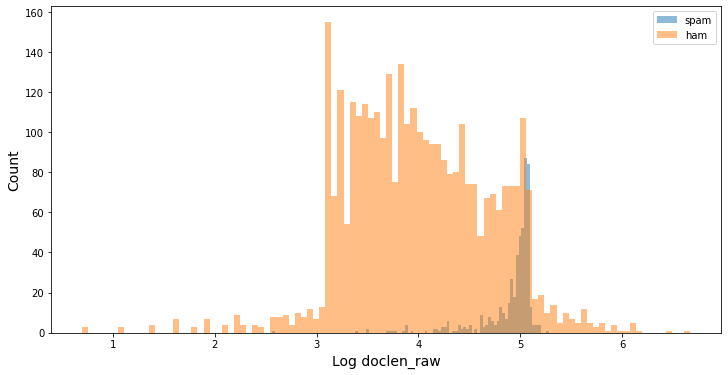

In [14]:
plot_target_hist(X_pos, X_neg, "doclen_raw", log_=True)

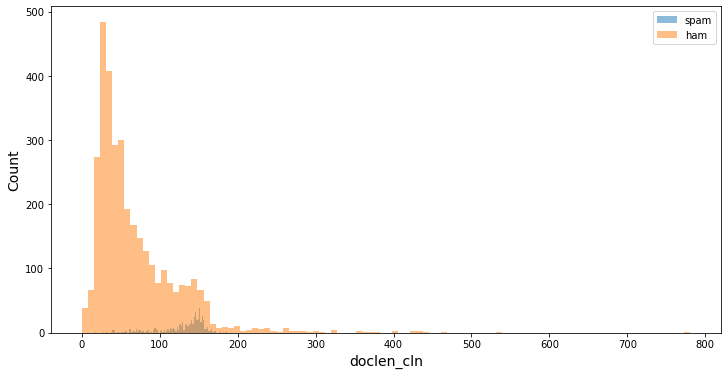

In [15]:
plot_target_hist(X_pos, X_neg, "doclen_cln")

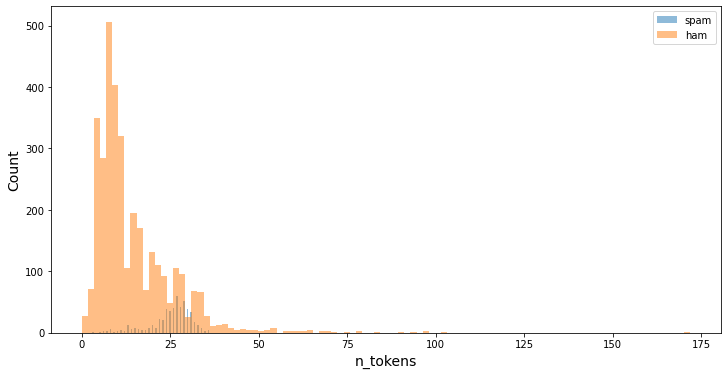

In [16]:
plot_target_hist(X_pos, X_neg, "n_tokens")

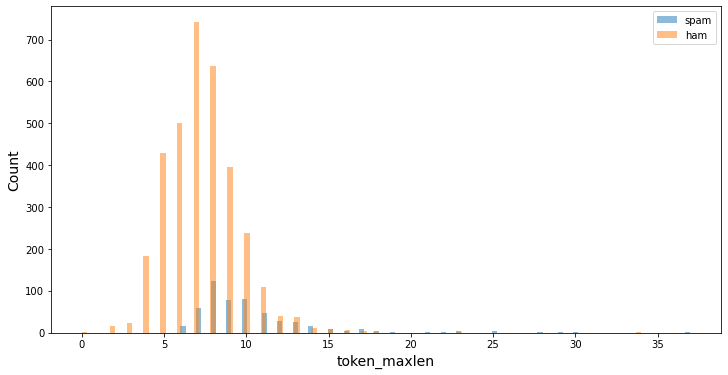

In [17]:
plot_target_hist(X_pos, X_neg, "token_maxlen")

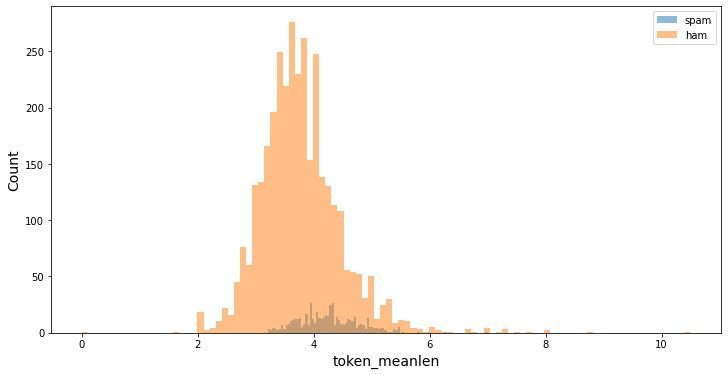

In [18]:
plot_target_hist(X_pos, X_neg, "token_meanlen")

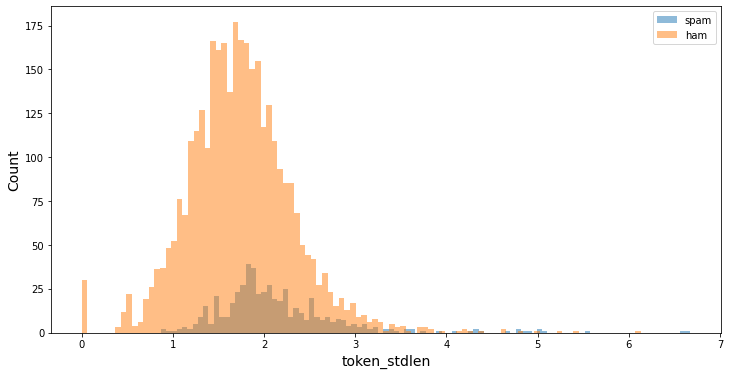

In [19]:
plot_target_hist(X_pos, X_neg, "token_stdlen")

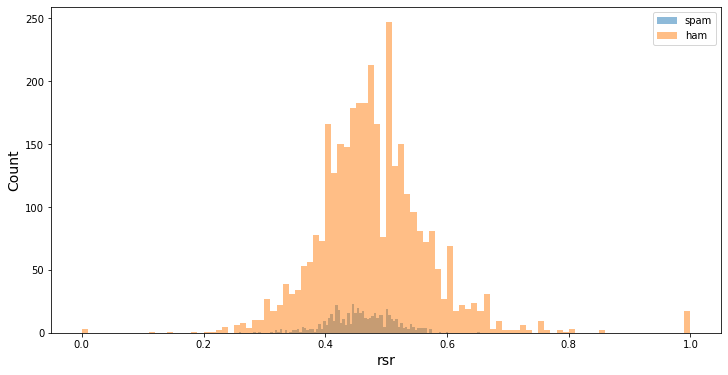

In [20]:
plot_target_hist(X_pos, X_neg, "rsr")

It's clear that some of the new features are more useful than others. The right-side ratio is probably the least informative with regards to the target, and the most informative is probably just the raw document length.

---

In [21]:
mins, secs = divmod(time.time() - start_time, 60)
print(f'Time elapsed: {mins:0.0f} m {secs:0.0f} s')

Time elapsed: 0 m 17 s
